In [43]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import norm, gaussian_kde, multivariate_normal
import KDEpy
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


## a) Explore the data using suitable methods and tools.

In [44]:
data = pd.read_csv('data_KDE_2D.csv')
data_array = data.to_numpy()
data

,X,Y
0,5.336130,8.064160
1,0.293243,3.939345
2,0.033378,2.282810
3,0.646273,1.968270
4,5.119659,3.580912
...,...,...
95,4.874246,5.170647
96,0.048707,-0.307987
97,0.278910,3.251409
98,5.023713,4.360683


In [45]:
print("Data Describe:\r\n", data.describe())
print("\r\nData Head:\r\n", data.head())

xval = np.arange(len(data.index))
plt.scatter(data['X'], data['Y'])

Data Describe:
                 X           Y
count  100.000000  100.000000
mean     2.778562    4.028618
std      2.110978    1.525876
min      0.030321   -0.307987
25%      0.813366    3.072323
50%      2.475870    3.956257
75%      4.701586    5.129715
max      7.672813    8.064160

Data Head:
           X         Y
0  5.336130  8.064160
1  0.293243  3.939345
2  0.033378  2.282810
3  0.646273  1.968270
4  5.119659  3.580912


#### Find an appropriate k for KMeans clustering: Method seen [towardsdatascience](https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d)

c:\users\fhs49456\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\users\fhs49456\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\users\fhs49456\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\users\fhs49456\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

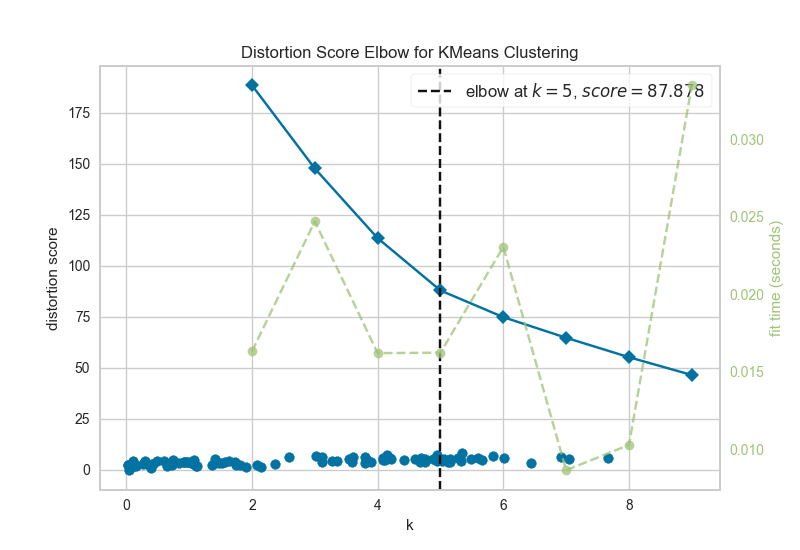

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [46]:
# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### No clear elbow point can be found! Let´s try the silhouette method. (Observing datapoints by eye: k should be around 2)

'\nThe following conditions should be checked to pick the right ‘K’ using the Silhouette plots:\n\n1.  For a particular K, all the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line).\n    The x-axis represents the Silhouette score. (Hold for all cluster!)\n2.  There should not be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points.\n    For K = 2, the best fit is shown, since other ks vary in size\n'

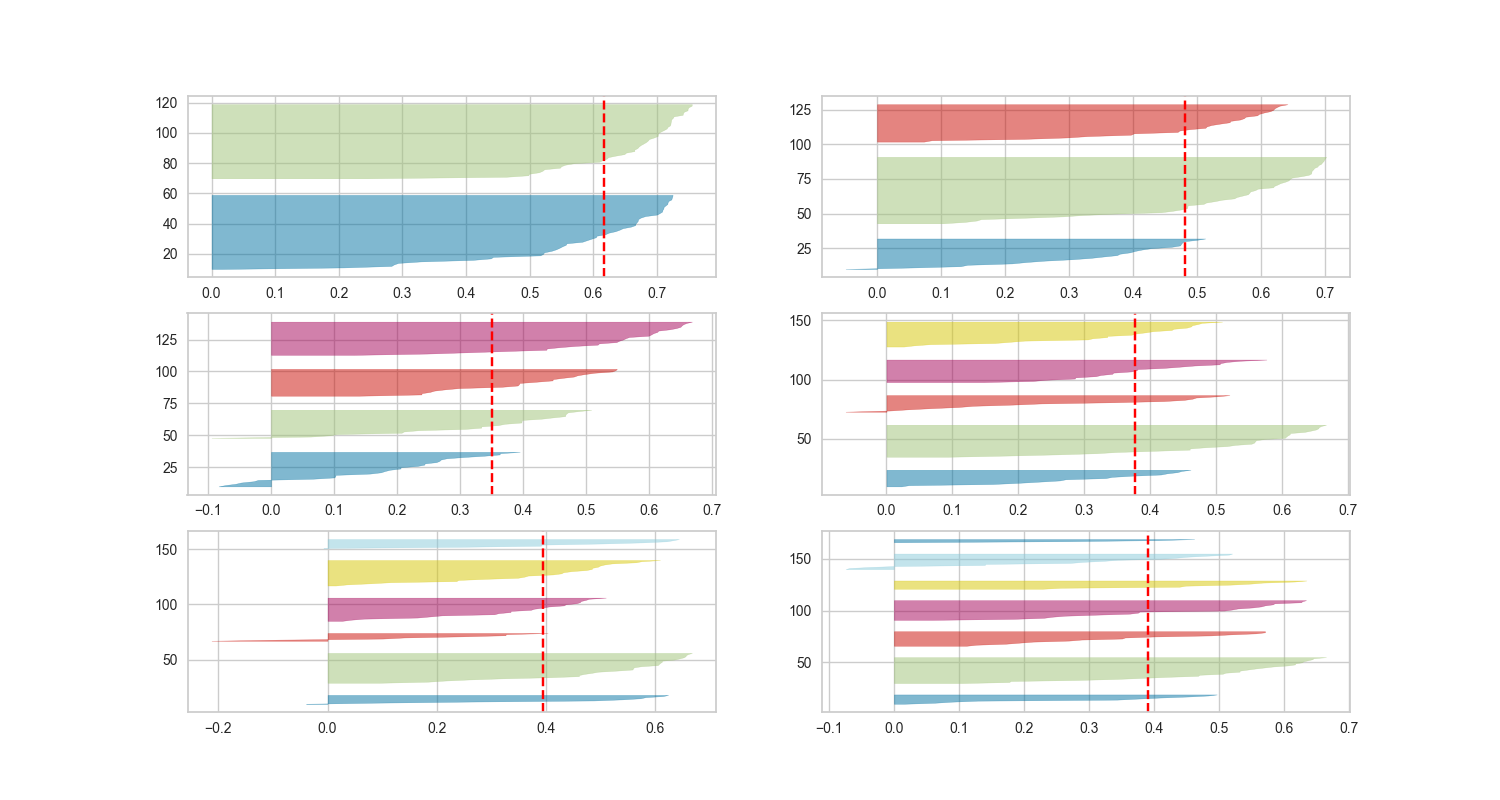

In [47]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data)

"""
The following conditions should be checked to pick the right ‘K’ using the Silhouette plots:

1.  For a particular K, all the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line).
    The x-axis represents the Silhouette score. (Hold for all cluster!)
2.  There should not be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points.
    For K = 2, the best fit is shown, since other ks vary in size
"""

c:\users\fhs49456\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


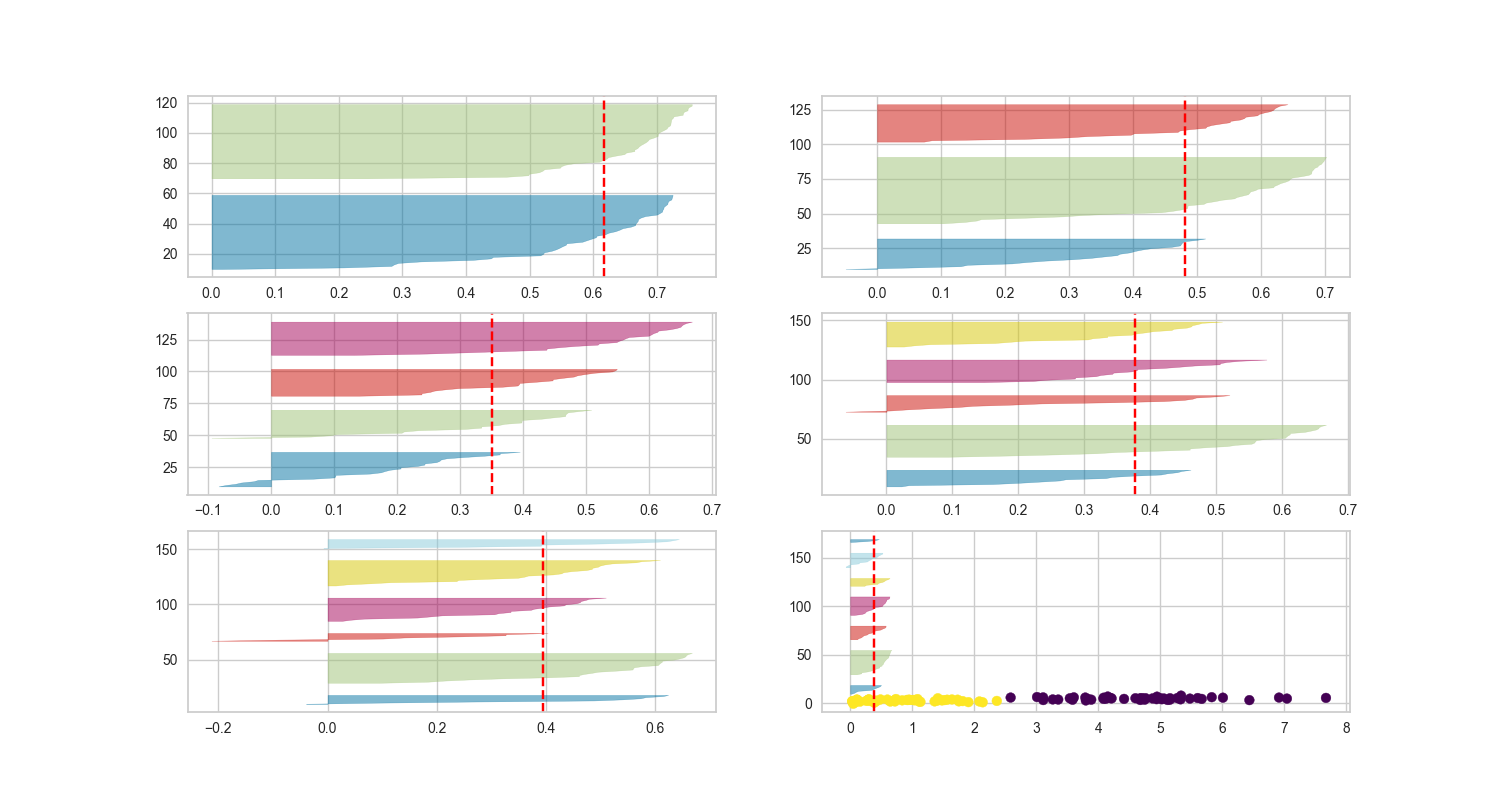

In [48]:
# So take k=2

kmean = KMeans(n_clusters=2).fit(data)
labels = kmean.predict(data)
data['label'] = labels
plt.scatter(data['X'], data['Y'], cmap='viridis', c=labels)
plt.show()

## b) Group the data to generate a meaningful histogram of the data

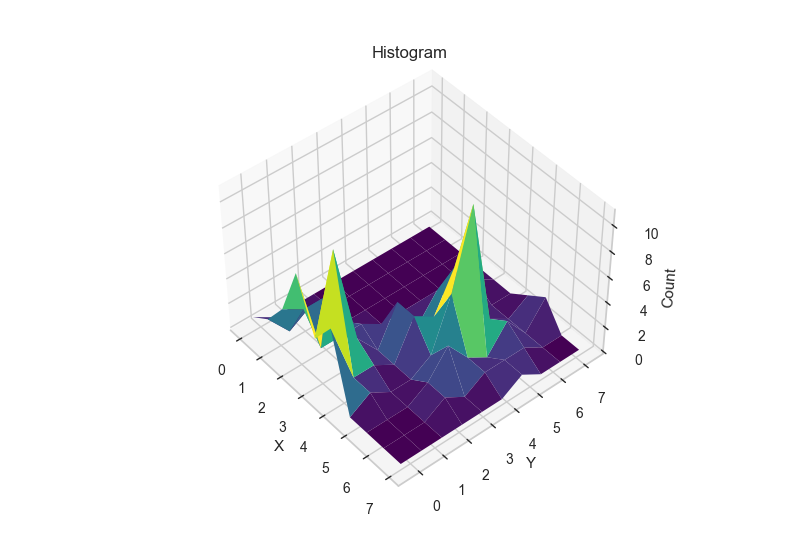

In [49]:
x = data['X']
y = data['Y']

# Generate 2D histogram (H contains the count)
H, xedges, yedges = np.histogram2d(x, y, bins=10)

# Create 3D plot
X, Y = np.meshgrid(xedges, yedges)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Count')
ax.set_title('Histogram')
ax.plot_surface(X[:-1, :-1], Y[:-1, :-1],H, cmap='viridis')
ax.view_init(elev=45, azim=320)

plt.show()

## c) Try to fit a normal distribution into the data. Plot the surface and contours of the fitted normal distribution on top of the data points.

In [50]:
cov = np.cov(data_array, bias=True)
cov

array([[ 1.86053672,  2.48666896,  1.53412969, ...,  2.02726674,
        -0.45219183,  2.37573408],
       [ 2.48666896,  3.32351544,  2.05041516, ...,  2.70950915,
        -0.60436936,  3.1752473 ],
       [ 1.53412969,  2.05041516,  1.26498655, ...,  1.67160909,
        -0.37286064,  1.95894236],
       ...,
       [ 2.02726674,  2.70950915,  1.67160909, ...,  2.20893809,
        -0.49271452,  2.58863296],
       [-0.45219183, -0.60436936, -0.37286064, ..., -0.49271452,
         0.1099024 , -0.57740733],
       [ 2.37573408,  3.1752473 ,  1.95894236, ...,  2.58863296,
        -0.57740733,  3.03359367]])

In [51]:
cov0 = np.diag([1.,1.])
data0 = data[data["label"]==0]
xvar0 = np.var(data0.iloc[:, 0])
yvar0 = np.var(data0.iloc[:, 1])
cov0[0][0] = xvar0
cov0[1][1] = yvar0

cov1 = np.diag([1.,1.])
data1 = data[data["label"]==1]
xvar1 = np.var(data1.iloc[:, 0])
yvar1 = np.var(data1.iloc[:, 1])
cov1[0][0] = xvar1
cov1[1][1] = yvar1

In [52]:
meanx0 = np.mean(data0["X"])
meany0 = np.mean(data0["Y"])

meanx1 = np.mean(data1["X"])
meany1 = np.mean(data1["Y"])

In [53]:
rv0 = multivariate_normal([meanx0, meany0], cov0)
pos0 = np.dstack((X, Y))
z0 = rv0.pdf(pos0)

rv1 = multivariate_normal([meanx1, meany1], cov1)
pos1 = np.dstack((X, Y))
z1 = rv1.pdf(pos1)

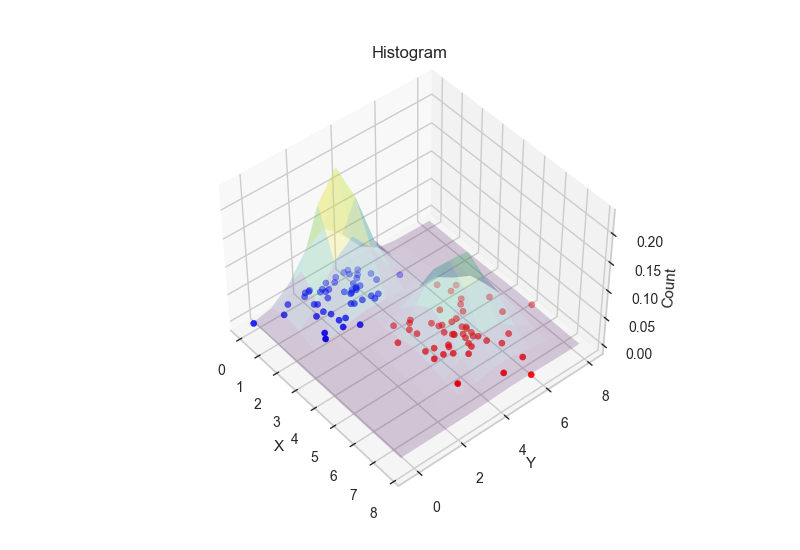

In [54]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Count')
ax.set_title('Histogram')
z = z0+z1
ax.scatter(data0["X"],data0["Y"],c="red")
ax.scatter(data1["X"],data1["Y"],c="blue")
ax.plot_surface(X, Y,z, cmap='viridis', alpha=0.2)


ax.view_init(elev=45, azim=320)

plt.show()

In [55]:
data

,X,Y,label
0,5.336130,8.064160,0
1,0.293243,3.939345,1
2,0.033378,2.282810,1
3,0.646273,1.968270,1
4,5.119659,3.580912,0
...,...,...,...
95,4.874246,5.170647,0
96,0.048707,-0.307987,1
97,0.278910,3.251409,1
98,5.023713,4.360683,0


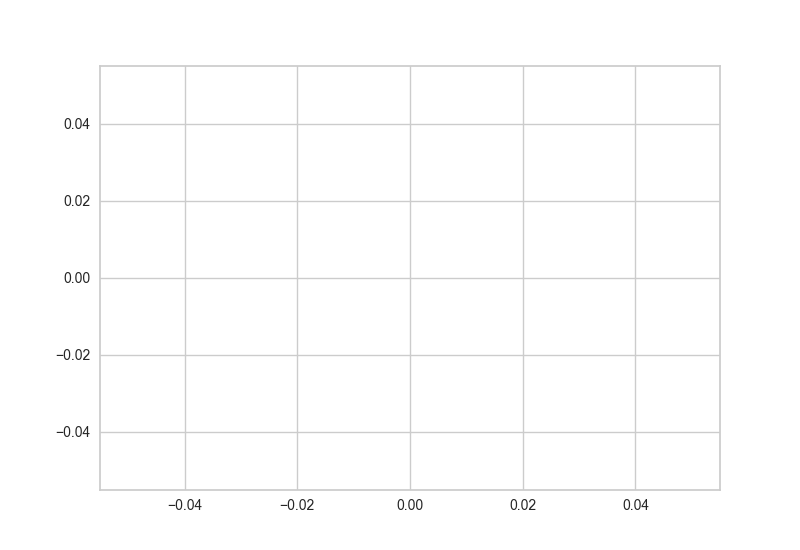

In [56]:
fig1 = plt.figure()

ax = fig1.add_subplot(111)

ax.plot()

plt.show()

## d) Multivariate kernel density estimation: Put a kernel (Gaussian, box, triangular) on top of every data point. Discuss the results.

## e) Vary the parameters of the kernels (bandwidth, weights, ...) used in (d) and combine them to get a KDE.